## PROJECT OVERVIEW
To detect any object that moves quickly and create a bounding box around it using **Sparse Blocks Network (SBNet)**. This project is currently used by **Uber**.

## OUTPUT EXPECTED

![GIF file](http://github.com/ak-ashwin/shared_files/blob/master/Output.gif?raw=true)

### Still Frame

![Image file](https://github.com/ak-ashwin/shared_files/blob/master/frame_16.jpg?raw=true)






#### Research Paper Links: 
1. [SBNet:Uber Blog](https://eng.uber.com/sbnet/)
2. [Research Paper](https://arxiv.org/abs/1801.02108)
3. [GitHub - uber/sbnet: Sparse Blocks Networks](https://github.com/uber/sbnet)
4. [SBNET - Youtube Link](https://www.youtube.com/watch?v=h0PdITBUjks)

#### Authors:
1. Mengye Ren
2. Andrei Pokrovsky
3. Bin Yang
4. Raquel Urtasun




## About SBNET

SBNET is a methodoloogy created by Uber to enable safe self driving cars. It basically uses Lidar functions and detects any moving objects quickly and creates a bounding box around in it and uses it to determine the location from the car and if the object is moving. It is used to improve response time and do this o GPU very quickly and accurately. 


SBNet performs this in 2 Steps:
1. Applying Max-pooling operation on the attention mask using overlapping blocks from the input tensor and converting it to a list of indices passed to a block-gather operation. 


![Step 1](http://eng.uber.com/wp-content/uploads/2018/01/image4-2-e1516053233377.png)


2. The gather operation then takes the tiles and stacks them together along the batch dimension into a new tensor.  Dense convolutions are then used and a customized scatter operation then performs an inverse operation writing the results on top of the original dense input tensor. Fig, below, shows our proposed sparse convolution mechanism using a sparse. 


![Step 2](http://eng.uber.com/wp-content/uploads/2018/01/image1-1.png)



### Uber's Github Code:

``` python
#load library
sbnet_module = tf.load_op_library('path_to_library/libsbnet.so')


#reduce_mask op converts a dense mask to a list of active block indices.

#In the following snippet the mask is expected to be a tensor of dimensions [N,H,W,1]:

#Step 1
    indices = sbnet_module.reduce_mask(
        mask, tf.constant([BCH, BCW], dtype=tf.int32),
        bsize=[BSZH, BSZW],
        boffset=[BOFFSH, BOFFSW],
        bstride=[BSTRH, BSTRW],
        tol=0.5, # pooling threshold to consider a block as active
        avgpool=True) # max pooling by default


```

``` python
#step 2
 blockStack = sbnet_module.sparse_gather(
        x,
        indices.bin_counts,
        indices.active_block_indices,
        bsize=[BSZH, BSZW], # block size
        boffset=[BOFFSH, BOFFSW], # block offset
        bstride=[BSTRH, BSTRW], # block stride
        transpose=do_transpose)
```



``` python
#step 3
  y = sbnet_module.sparse_scatter(
        blockStack,
        indices.bin_counts,
        indices.active_block_indices,
        x, # base tensor to copy to output and overwrite on top of
        bsize=[BSZH, BSZW],
        boffset=[BOFFSH, BOFFSW],
        bstride=[BSTRH, BSTRW],
        add=do_add,
        atomic=False, # use atomic or regular adds
        transpose=do_transpose)
```



## Let's Begin:

#### Creating the dataset:

``` python
from IPython.display import Image

import cv2

print(cv2.__version__)

import numpy as np

cap = cv2.VideoCapture('/Users/sbnet/files/traffic.mp4')

count = 0
#  VIDEO PROPERTIES
print("Frame Width : ")
print(cap.get(3))  # Frame Width
print("Frame Height :")
print(cap.get(4))  # Frame Height
fps = (cap.get(cv2.CAP_PROP_FPS))
print("FPS :", fps)

fullmask = cv2.createBackgroundSubtractorMOG2()
while (cap.isOpened):
    ret, frame = cap.read()
    fgmask = fullmask.apply(frame)
    if fgmask is None:
        break
    (im2, contours, hierarchy) = cv2.findContours(fgmask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        if cv2.contourArea(c) < 650:
            continue

        filename = "/Users/sbnet/frames/frame_%d.jpg" % count
        # resize image
        resized_frame = cv2.resize(frame, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(filename, resized_frame)

        filename = "/Users/sbnet/fgmask/fgmask_%d.jpg" % count
        # resize image
        resized_fgmask = cv2.resize(fgmask, (128,128), interpolation=cv2.INTER_AREA)
        cv2.imwrite(filename, resized_fgmask)
        count = count + 1

    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

```


##### Output images - the frame and the mask files

##### 1. With Vehicles

##### Frame :
![Frame](https://github.com/ak-ashwin/shared_files/blob/master/frame_15.jpg?raw=true)


##### Mask :
![Mask](https://github.com/ak-ashwin/shared_files/blob/master/fgmask_15.jpg?raw=true)




##### 2. Without Vehicles

##### Frame :
![Frame](https://github.com/ak-ashwin/shared_files/blob/master/no_vehicles_frame_1.jpg?raw=true)

##### Mask :
![Mask](https://github.com/ak-ashwin/shared_files/blob/master/no_vehicles_mask_1.jpg?raw=true)




##### Now convert images into numpy arrays


``` python
import numpy as np
import cv2
# if you dont have opencv, use skimage or pil
import pickle
import bz2
import os


def save(name, to_save):
    sfile = bz2.BZ2File(name, 'w')
    pickle.dump(to_save, sfile)
    sfile.close()


def load(name):
    sfile = bz2.BZ2File(name, 'rb')
    data = pickle.load(sfile)
    sfile.close()
    return data


def process(DIR, color=1):
    '''
    DIR is the directory which contains the images
    color = 1 reads in RGB,  color = 0 reads in greyscale
    '''
    STORE_DIR = "numpy_array/"
    image_list = os.listdir(os.path.join(ROOT_DIR, DIR))
    if '.DS_Store' in image_list:
        image_list.remove('.DS_Store')
    image_list.sort()
    for i in range(len(image_list)):
        if i == 0:
            img = cv2.imread(os.path.join(ROOT_DIR, DIR, image_list[i]), color)
            img_shape = img.shape
            # torch expects tensors in shape N,C,H,W unlike keras,(N,H,W,C)
            data = np.empty((0, img_shape[2], img_shape[0], img_shape[1]))
            img = np.swapaxes(img, 0, 2)
            img = np.swapaxes(img, 1, 2)
            data = np.concatenate((data, img[np.newaxis, :, :, :]), axis=0)
        else:
            img = cv2.imread(os.path.join(ROOT_DIR, DIR, image_list[i]), color)
            img = np.swapaxes(img, 0, 2)
            img = np.swapaxes(img, 1, 2)
            data = np.concatenate((data, img[np.newaxis, :, :, :]), axis=0)
    save(STORE_DIR + DIR + ".bz2", data)
    return data


# test = process("no_vehicles_frames")
# print(test.shape)

ROOT_DIR = "/Users/sbnet/images_sbnet_convert_images_to_numpy/images_sbnet"

# data_list = os.listdir(ROOT_DIR)
if '.DS_Store' in data_list:
    data_list.remove('.DS_Store')
print(data_list)

for i in data_list:
    process(i)


```



##### We get an output of both mask and frames in bz2 format

1. no_vehicles_frames.bz2
2. no_vehicles_mask.bz2
3. vehicles_fgmask.bz2
4. vehicles_frames.bz2


In [0]:
# !rm -rf *
#  ls

images_sbnet_200.zip


In [0]:
!wget --header="Host: doc-0g-a0-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Cookie: AUTH_7bi5q9b851v5qgp5s7m582qmpk6mlqmd=17241037231885297069|1529841600000|bt72qfi949p1f991ht4a6g6vhf849ub4" --header="Connection: keep-alive" "https://doc-0g-a0-docs.googleusercontent.com/docs/securesc/hv524mehckc7hlhuknf5ls6rniouvmtr/krli8bjbr4g89jj8ji3vasetnqdqcgih/1529848800000/17241037231885297069/17241037231885297069/1F1PdC2e7A1waiZA9BR5ywKjIKzH5AFU6?h=09910226885230189022&e=download" -O "images_sbnet_200.zip" -c

--2018-06-24 19:08:11--  https://doc-0g-a0-docs.googleusercontent.com/docs/securesc/hv524mehckc7hlhuknf5ls6rniouvmtr/krli8bjbr4g89jj8ji3vasetnqdqcgih/1529848800000/17241037231885297069/17241037231885297069/1F1PdC2e7A1waiZA9BR5ywKjIKzH5AFU6?h=09910226885230189022&e=download
Resolving doc-0g-a0-docs.googleusercontent.com (doc-0g-a0-docs.googleusercontent.com)... 66.102.1.132, 2a00:1450:400c:c06::84
Connecting to doc-0g-a0-docs.googleusercontent.com (doc-0g-a0-docs.googleusercontent.com)|66.102.1.132|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
!unzip images_sbnet_200.zip


Archive:  images_sbnet_200.zip
replace images_sbnet_200/no_vehicles_frames.bz2? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
import numpy as np

#pytorch
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install -q torchvision
import torch
print("pytorch version: ", torch.__version__)

tcmalloc: large alloc 1073750016 bytes == 0x5d9b8000 @  0x7f8f0aee91c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
pytorch version:  0.4.0


In [0]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np 
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import DataLoader 
import torch.nn.functional as F

# import keras
# from keras.datasets import mnist

In [0]:
!pip3 install ipdb

  Running setup.py bdist_wheel for ipdb ... - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/a8/0e/e2/ffc7bedd430bfd12e9dba3c4dd88906bc42962face85bc4df7
Successfully built ipdb


In [0]:
ls

datalab/  images_sbnet_200/  images_sbnet_200.zip


In [0]:
import pickle
import bz2
import os

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [0]:
cd images_sbnet_200

/content/images_sbnet_200


In [0]:
ls

no_vehicles_frames.bz2  vehicles_fgmask.bz2
no_vehicles_mask.bz2    vehicles_frames.bz2


In [0]:
def load(name):
	sfile = bz2.BZ2File(name, 'rb')
	data = pickle.load(sfile)
	sfile.close()
	return data

data1 = load("no_vehicles_frames.bz2")
data1_mask = load("no_vehicles_mask.bz2")
data2 = load("vehicles_frames.bz2")
data2_mask = load("vehicles_fgmask.bz2")



data1 = torch.Tensor(data1).to(device)
data1_mask = torch.Tensor(data1_mask).to(device)
data2 = torch.Tensor(data2).to(device)
data2_mask = torch.Tensor(data2_mask).to(device)
print(data1.size())


torch.Size([200, 3, 128, 128])


In [0]:
x_train = torch.cat((data1, data2), 0).to(device)
# no. of images = 200
y_train = torch.cat((torch.zeros(200,1), torch.ones(200,1)), 0).to(device)
mask = torch.cat((data1_mask, data2_mask), 0).to(device)

x_train = x_train/255
Mask = (mask > (1/255)).float()
Mask = Mask[:,0,:,:]
Mask.require_grad = False


In [0]:
# mask=Mask.clone()


In [0]:
# mask[Mask==0]=1
# mask[Mask==1]=0

In [0]:
# mask.shape

torch.Size([400, 128, 128])

In [0]:
# Added code below.

In [0]:
# number of images = 200
labels = torch.cat((torch.zeros(200,), torch.ones(200,)), 0).long().to(device)


In [0]:
labels.shape

torch.Size([400])

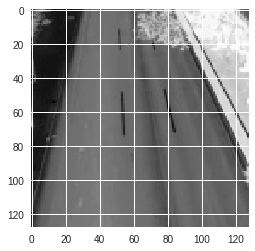

In [0]:
#viusalize !

import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(x_train[0, 0, :, :].cpu().detach().numpy())

In [0]:
mask.cpu().detach().numpy()

array([[[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        ...,
        [1., 0., 1., ..., 1., 1., 1.],
        [0., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        ...,
        [1., 0., 1., ..., 1., 1., 1.],
        [0., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        ...,
        [1., 0., 1., ..., 1., 1., 1.],
        [0., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0.

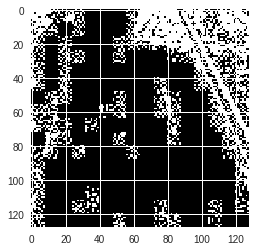

In [0]:
plt.imshow(mask[5].cpu().detach().numpy())

In [0]:
Mask.shape

torch.Size([400, 128, 128])

X_train.shape

In [0]:
num_epochs = 5
num_classes = 2
batch_size = 16
learning_rate = 0.01
#img_channel, img_height, img_width = x_train.shape[0], x_train.shape[1], x_train.shape[2]
img_channel, img_height, img_width = x_train.shape[1], x_train.shape[2], x_train.shape[3]

In [0]:
print(img_channel, img_height, img_width)

3 128 128


In [0]:
def reduce_mask_pool2d(mask, ksize, kstride, thresh = 0.2, avg= True):
	'''
	Reduce mask operation:Takes a binary mask as input and after performing 
	avg pooling or max pooling selects active blocksand return indices of 
	the active blocks
	
	Inputs:
	:param mask:		torch tensor	#[N,H,W] binary mask, where N is batch diemension, W, H are width and height of mask
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel
	:param thresh:		int 			#applicable for avg pooling
	:param avg:			bool 			#Avg pooling or max pooling 

	Require_grad = Fasle

	Output:
		indicies of size [B, 3] where B is the number of active blocks 
		and 3 corresponds to [N, y, x] where N is batch size, and (y,x) is the 
		co-ordinates of the "centre" of the block.
		indicies is a torch tensor
	Note:
		padding is done automatically
	'''

	assert torch.is_tensor(mask) == True, 'Expect mask to be a pytorch tensor'
	isize = list(mask.size())
	assert len(mask.size()) == 3 , 'Expect input rank = 3'
	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
	assert type(thresh) in [int, float], 'Expect `thresh` to be int or float'

	mask = mask.unsqueeze(1)

	if avg:
		temp = F.avg_pool2d(input = mask, kernel_size = ksize, stride = kstride, padding = 0).to(device).squeeze()
		indicesm = torch.where(temp > thresh, torch.ones_like(temp).to(device), torch.zeros_like(temp).to(device)).int()
		indices = (indicesm != 0).nonzero().to(device)
		return indices
	else:
		temp = F.max_pool2d(input = mask, kernel_size = ksize, stride = kstride, padding = 0).to(device).squeeze()
		indicesm = torch.where(temp > thresh, torch.ones_like(temp).to(device), torch.zeros_like(temp).to(device)).int()
		indices = (indicesm != 0).nonzero().to(device)
		return indices

In [0]:
def pad_input(input, ksize, kstride):
	'''
	Pads the input or mask according to the required kernel to perform sparse convolution

	Inputs:
	:param input:		torch tensor	#[N,H,W] binary mask or [N,C,H,W] input, where N is batch
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel

	Output: Zero padded torch tensor
	'''
	assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
	isize = list(input.size())
	assert len(input.size()) == 3 or len(input.size()) == 4, 'Expect input rank = 3(mask) or 4(input)'
	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

	#padding along width!
	pad_w = kstride[-1] - ((isize[-1]-ksize[-1])%kstride[-1])
	pad_w1 = pad_w2 = pad_w//2
	if pad_w%2 == 1:
		pad_w2 += 1

	#padding along height
	pad_h = kstride[-2] - ((isize[-2]-ksize[-2])%kstride[-2])
	pad_h1 = pad_h2 = pad_h//2
	if pad_h%2 == 1:
		pad_h2 += 1

	pad = (pad_w1, pad_w2, pad_h1, pad_h2)
	return F.pad(input, pad, "constant", 0).to(device)

In [0]:
def gather2d(input, indices, ksize, kstride):
	'''
	Sparse gather operation:

	Takes a torch tensor as input and gathers blocks on basis of indices generated 
	from reduce_mask_pool2d. Essentialy a slicing and concatenation along the batch dimension

	Params:
	:param input:		torch tensor	#[N,C,H,W] size tensor, where N is batch diemension, W, H are width and height of mask 
	:param indices:		torch tensor 	#[B,3] where B is the number of active blocks and 3 corresponds to [N,y,x]
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel

	Output:
		Returns a [B,C,h,w] shape tensor which is the active blocks stacked in the 
		batch diemension
	gradient flow is fine: https://github.com/pytorch/pytorch/issues/822
	
	Problems? : How to remove the for loop and vectorize it?
	idea: flatten and multiply and reshape !
	'''
	assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
	isize = list(input.size())
	assert len(input.size()) == 4, 'Expect input rank = 4 , [N,C,H,W]'

	assert torch.is_tensor(indices) == True, 'Expect indicies to be a pytorch tensor'
	asize = list(indices.size()) 

	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

	#gathered = torch.empty((asize[0], isize[1], ksize[0], ksize[1])).to(device)
	gathered = input[indices[0][0]:indices[0][0]+1, :, indices[0][1]*kstride[0]:indices[0][1]*kstride[0]+ksize[0], indices[0][2]*kstride[1]: indices[0][2]*kstride[1]+ksize[1]]
	for B, h0, w0 in indices[1:]:
		gathered = torch.cat((gathered, input[B:B+1, :, h0*kstride[0]:h0*kstride[0]+ksize[0], w0*kstride[1]: w0*kstride[1]+ksize[1]]), 0)
	return gathered



In [0]:
def gather2dd(input, indices, ksize, kstride):
	'''
	Sparse gather operation:

	Takes a torch tensor as input and gathers blocks on basis of indices generated 
	from reduce_mask_pool2d. Essentialy a slicing and concatenation along the batch dimension

	Params:
	:param input:		torch tensor	#[N,C,H,W] size tensor, where N is batch diemension, W, H are width and height of mask 
	:param indices:		torch tensor 	#[B,3] where B is the number of active blocks and 3 corresponds to [N,y,x]
	:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
	:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel

	Output:
		Returns a [B,C,h,w] shape tensor which is the active blocks stacked in the 
		batch diemension
	gradient flow is fine: https://github.com/pytorch/pytorch/issues/822
	
	Problems? : How to remove the for loop and vectorize it?
	idea: flatten and multiply and reshape !
	'''
	assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
	isize = list(input.size())
	assert len(input.size()) == 3, 'Expect input rank = 4 , [N,C,H,W]'

	assert torch.is_tensor(indices) == True, 'Expect indicies to be a pytorch tensor'
	asize = list(indices.size()) 

	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

	#gathered = torch.empty((asize[0], isize[1], ksize[0], ksize[1])).to(device)
	gathered = input[indices[0][0]:indices[0][0]+1, indices[0][1]*kstride[0]:indices[0][1]*kstride[0]+ksize[0], indices[0][2]*kstride[1]: indices[0][2]*kstride[1]+ksize[1]]
	for B, h0, w0 in indices[1:]:
		gathered = torch.cat((gathered, input[B:B+1, h0*kstride[0]:h0*kstride[0]+ksize[0], w0*kstride[1]: w0*kstride[1]+ksize[1]]), 0)
	return gathered

In [0]:
def mask_pool2d(mask):
	'''
	mask downsample operation:Takes a binary mask as input and performs max
	pooling to reduce its size 
	
	Inputs:
	:param mask:		torch tensor	#[N,H,W] binary mask, where N is batch diemension, W, H are width and height of mask
	
	Outputs: A binary torch tensor of half the input mask size
	'''
	assert torch.is_tensor(mask) == True, 'Expect mask to be a pytorch tensor'
	isize = list(mask.size())
	assert len(mask.size()) == 3 , 'Expect input rank = 3'

	mask = mask.unsqueeze(1)
	temp = F.max_pool2d(input = mask, kernel_size = [2,2], stride = [2,2], padding = 0).to(device).squeeze().float()
	temp.require_grad = False
	return temp


In [0]:
def scatter2d(input, gathered, indices, ksize, kstride, add = True):
	'''
	Sparse scatter operation:

	Takes a gathered torch tensor as input and scatters it back on the input on basis of
	indices generated from reduce_mask. Essentialy a slicing and addition/write operation

	Params:
		:param input:		torch tensor	#[N,C,H,W] size tensor, where N is batch diemension, W, H are width and height of mask 
		:param gathered:	torch tensor 	#[B,C,h1,w1] B,C are same as the input, h1 and w1 are deetermined on the type of convolutions used
		:param indices:		torch tensor 	#[B,3] where B is the number of active blocks and 3 corresponds to [N,y,x]
		:param kszie:		[list, tuple]	#[h,w] Size of kernel to perform pooling
		:param kstride:		[list, tuple] 	#[h_stride,w_stride] Stride of Kernel
		:param add:			bool 			#Decides weather to add the values or replace them while scattering
	Output:
		A tensor of same shape as input, but it has been updatd with the scattered values
	'''
	assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
	assert len(input.size()) == 4, 'Expect input rank = 4 , [N,C,H,W]'

	assert torch.is_tensor(indices) == True, 'Expect indicies to be a pytorch tensor'

	assert torch.is_tensor(gathered) == True, 'Expect gathered to be a pytorch tensor'
	gsize = list(gathered.size())

	assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
	assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
	assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

	count_index = 0
	for B, h0, w0 in indices:
		if add:
			input[B, :, h0*kstride[0]:h0*kstride[0]+gsize[2], w0*kstride[1]: w0*kstride[1]+gsize[3]] += gathered[count_index]
		else:
			input[B, :, h0*kstride[0]:h0*kstride[0]+gsize[2], w0*kstride[1]: w0*kstride[1]+gsize[3]] = gathered[count_index]
		count_index += 1

In [0]:
#I wrapped the functions gather and scatter in  nn.Module class to allow easier flow of gradients
class gather2dc(nn.Module):
	def __init__(self, ksize, kstride):
		super(gather2dc, self).__init__()
		self.ksize = ksize
		self.kstride = kstride

	def forward(self, input, indices):
		gathered = input[indices[0][0]:indices[0][0]+1, :, indices[0][1]*self.kstride[0]:indices[0][1]*self.kstride[0]+self.ksize[0], indices[0][2]*self.kstride[1]: indices[0][2]*self.kstride[1]+self.ksize[1]]
		for B, h0, w0 in indices[1:]:
			gathered = torch.cat((gathered, input[B:B+1, :, h0*self.kstride[0]:h0*self.kstride[0]+self.ksize[0], w0*self.kstride[1]: w0*self.kstride[1]+self.ksize[1]]), 0)
		return gathered


class scatter2dc(nn.Module):
	def __init__(self, kstride):
		super(scatter2dc, self).__init__()
		self.kstride = kstride

	def forward(self, input, gathered, indices):
		gsize = list(gathered.size())
		#back = torch.zeros_like(input)
		count_index = 0
		for B, h0, w0 in indices:
				input[B, :, h0*self.kstride[0]:h0*self.kstride[0]+gsize[2], w0*self.kstride[1]: w0*self.kstride[1]+gsize[3]] = gathered[count_index]
				count_index +=1
		#return torch.cat((input, back), 1)
		return input

In [0]:
class sparse_block(nn.Module):
	def __init__(self, inp_ch, out_ch, ksize, kstride, block_layers = None, thresh = 0.2):
		super(sparse_block, self).__init__()

		assert type(block_layers) in [type(None), torch.nn.modules.container.Sequential], 'Expect block_layers as None or torch.nn.Sequential() object' 
		assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
		assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
		assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
		assert type(inp_ch) in [int, float], 'inp_ch should be int or float'
		assert type(out_ch) in [int, float], 'out_ch should be int or float'
		self.ksize = ksize
		self.kstride = kstride
		self.thresh = thresh
		self.g = gather2dc(ksize, kstride)
		self.c = scatter2dc(kstride)
		self.channel_control =  nn.Sequential(
			nn.Conv2d(inp_ch, out_ch, 1, padding = 0),
			nn.ReLU(),
            nn.BatchNorm2d(out_ch)).to(device)

		if block_layers == None:
			self.operation = nn.Sequential(
				nn.Conv2d(out_ch, 2*out_ch, 1, padding = 0),
				nn.ReLU(),
				nn.BatchNorm2d(2*out_ch),
				nn.Conv2d(2*out_ch, 2*out_ch, 3, padding = 1),
				nn.ReLU(),
				nn.BatchNorm2d(2*out_ch), #can be made as deep as required!
				nn.Conv2d(2*out_ch, out_ch, 1, padding = 0),
				nn.ReLU(),
				nn.BatchNorm2d(out_ch)
				).to(device)
		else:
			self.operation = block_layers.to(device)

	def forward(self, x, mask):
		x = self.channel_control(x)
		mask = pad_input(mask, self.ksize, self.kstride)
		mask.require_grad = False
		x = pad_input(x, self.ksize, self.kstride)
		x.require_grad = True

		indices = reduce_mask_pool2d(mask, self.ksize, self.kstride, self.thresh, avg= True)
		gathered = self.g(x, indices)
		### Here the custom conv operations are done
		gathered = self.operation(gathered)
		#print(gathered.size())
		x = self.c(x, gathered, indices)
		return x

In [0]:
class net(nn.Module):
    def __init__(self, inp_ch, num_classes):
        super(net, self).__init__()
        self.sparse1 = sparse_block(inp_ch, 16, [5,5], [4,4], thresh = 0.05)
        self.mp1 = nn.MaxPool2d(2)
        self.sparse2 = sparse_block(16, 32, [5,5], [4,4], thresh = 0.05)
        self.mp2 = nn.MaxPool2d(2)
        self.fc = nn.Sequential(
            nn.Linear(32*32*32, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes-1),
            #nn.Softmax(dim=1)
            nn.Sigmoid()
            )

    def forward(self, x, mask1):
        x = self.sparse1(x, mask1)
        x = self.mp1(x)
        mask2 = mask_pool2d(mask1)
        x = self.sparse2(x, mask2)
        #maps.append(x[0])
        x = self.mp2(x)
        #print(x.size()) #####################################
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

In [0]:

model = net(img_channel, num_classes).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)


In [0]:
#train
num_epochs = 5
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    print("\nEpoch = ", epoch)
    z = 0
    for i in range(len(x_train)//batch_size): # len(X_train) is 40 and batch size is 4
        x = x_train[z:z+batch_size, :, :, :]
        y = y_train[z:z+batch_size]
        mask_new = Mask[z:z+batch_size, :, :]
        z += batch_size
        Label = labels[z:z+batch_size]

        #Forward pass
        output = model(x, mask_new)
        #print(output, y)
        loss = criterion(output, y)
        
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#         print(epoch_loss)
        if (z%10 == 0):
          #_, predicted = torch.max(output.data, 1)
          #print(predicted)
          #total = batch_size
          #correct = (predicted == Label ).sum().item()
          #print('\rStep [{}/{}], Loss: {:.4f}'.format(i, 10, epoch_loss/i), end = ' ')
          print('\rStep [{}/{}], Loss: {:.4f}'.format(i, len(x_train)//batch_size, epoch_loss/i), end = ' ')
            


    #break
#break
                


### Conclusion:

We finally managed to get loss at 15.45% after running it for 10 Epochs.


##### Problems faced :

1. Executing code on AWS
The github link shared was not executing completely. 
We encountered many configuration issues and we mangaed to run the test file on AWS.
Finally, using cuda we could we couldn't get it to run on AWS and Google Colab.

We had got some help and we ended writing sbnet code in pytorch. 


We also wrote to the authors of this paper and Mengye Ren responded!



Next Steps:
1. To increase accuracy by increasing the number of epochs
2. TO implement the entire code using CUDA
3. Prediction of vehicles moving when you insert an image.



Special Thanks:
1. Pavithra
2. Anand Mooga
3. Mengye Ren (Author)

